In [1]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import os
import random
from src.loader import preprocess_audio
from src.umodel import StegoUNet, VoiceCloner
from src.losses import calc_ber, signal_noise_ratio, batch_calc_ber
from src.loader import StegoDataset
from torch.utils.data import DataLoader

from dotenv import load_dotenv
from datasets import load_dataset
import matplotlib.pyplot as plot
from IPython.display import Audio
load_dotenv()

True

In [2]:
def parse_keyword(keyword):
    if isinstance(keyword, bool): return keyword
    if keyword.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif keyword.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Wrong keyword.')


parser = argparse.ArgumentParser()

parser.add_argument('--stft_small',
                    type=parse_keyword,
                    default=True,
                    metavar='BOOL',
                    help='If [fourier], whether to use a small or large container'
                    )
parser.add_argument('--ft_container',
                    type=str,
                    default='mag',
                    metavar='STR',
                    help='If [fourier], container to use: [mag], [phase], [magphase]'
                    )
parser.add_argument('--mp_encoder',
                    type=str,
                    default='single',
                    metavar='STR',
                    help='If [fourier] and [magphase], type of magphase encoder: [single], [double]'
                    )
parser.add_argument('--mp_decoder',
                    type=str,
                    default='unet',
                    metavar='STR',
                    help='If [fourier] and [magphase], type of magphase encoder: [unet], [double]'
                    )
parser.add_argument('--mp_join',
                    type=str,
                    default='mean',
                    metavar='STR',
                    help='If [fourier] and [magphase] and [decoder=double], type of join operation: [mean], [2D], [3D]'
                    )
parser.add_argument('--permutation',
                    type=parse_keyword,
                    default=False,
                    metavar='BOOL',
                    help='Permute the encoded image before adding it to the audio'
                    )
parser.add_argument('--embed',
                    type=str,
                    default='stretch',
                    metavar='STR',
                    help='Method of adding the image into the audio: [stretch], [blocks], [blocks2], [blocks3], [multichannel], [luma]'
                    )
parser.add_argument('--luma',
                    type=parse_keyword,
                    default=False,
                    metavar='BOOL',
                    help='Add luma component as the fourth pixelshuffle value'
                    )
parser.add_argument('--num_points',
                    type=int,
                    default=16000,
                    help="the length model can handle")
parser.add_argument('--n_fft',
                    type=int,
                    default=1000)
parser.add_argument('--hop_length',
                    type=int,
                    default=400)
parser.add_argument("--mag",
                   type=bool,
                   default=False)
parser.add_argument("--num_layers",
                   type=int,
                   default=4)
parser.add_argument('--transform',
                    type=str,
                    choices=["ID", "TC", "RS", "VC"],
                    default="ID",
                   )
parser.add_argument("--watermark_len",
                    type=int,
                    default=8)
parser.add_argument("--dataset_i",
                    type=int,
                    choices=[0, 1],
                    default=0)
parser.add_argument("--shift_ratio",
                    type=float,
                    default=0
                    )
parser.add_argument('--share_param',
                    type=parse_keyword,
                    default=False,
                    metavar='BOOL'
                    )

def set_reproductibility(seed=2023):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
set_reproductibility()

pattern = [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
           0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
           1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
           1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
           0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
pattern = [0, 1, 1, 1, 1, 0, 1, 1, 0 ,1, 1, 1, 1, 1, 1, 1, 1 ,1, 0, 0, 1,
           0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

args = parser.parse_args("")
print(args)

Using device: cuda
Namespace(stft_small=True, ft_container='mag', mp_encoder='single', mp_decoder='unet', mp_join='mean', permutation=False, embed='stretch', luma=False, num_points=16000, n_fft=1000, hop_length=400, mag=False, num_layers=4, transform='ID', watermark_len=8, dataset_i=0, shift_ratio=0, share_param=False)


In [4]:
# load dataset
DATA_FOLDER = os.environ.get('DATA_PATH')
AUDIO_FOLDER = f"{DATA_FOLDER}/LibrispeechVoiceClone_"
dataset = StegoDataset(
        audio_root_i=args.dataset_i,
        folder="test",
        num_points=48000,
        watermark_len=args.watermark_len,
        shift_ratio=args.shift_ratio
    )

DATA LOCATED AT: /home/rz60/data/LibrispeechVoiceClone_test
Set up done


In [400]:
# load model
model = StegoUNet(
        transform=args.transform,
        num_points=args.num_points,
        n_fft=args.n_fft,
        hop_length=args.hop_length,
        mag=args.mag,
        num_layers=args.num_layers,
        watermark_len=args.watermark_len,
        shift_ratio=args.shift_ratio,
        share_param=args.share_param
    )
model2 = StegoUNet(
        transform=args.transform,
        num_points=args.num_points,
        n_fft=args.n_fft,
        hop_length=args.hop_length,
        mag=args.mag,
        num_layers=args.num_layers,
        watermark_len=args.watermark_len,
        shift_ratio=args.shift_ratio,
        share_param=args.share_param
    )

# Load checkpoint
ckpt_path = '1-wavmarkConfig_wl32lr1e-4audioMSElosslam100/9-1-wavmarkConfig_wl32lr1e-4audioMSElosslam100.pt'
ckpt_path = '1-multi_IDwl16lr1e-4audioMSElam100/30-1-multi_IDwl16lr1e-4audioMSElam100.pt'
ckpt_path = '1-multi_WMwl16lr1e-4audioMSElam100/23-1-multi_WMwl16lr1e-4audioMSElam100.pt'
# ckpt_path = "1-multi_step2_WMwl16lr1e-6audioMSElam100/7-1-multi_step2_WMwl16lr1e-6audioMSElam100.pt"
ckpt_path = '1-multi_step2_WMwl16lr1e-5audioMSElam1e4alpha1e4/7-1-multi_step2_WMwl16lr1e-5audioMSElam1e4alpha1e4.pt'

ckpt_path = '1-multi_IDwl8lr1e-4audioMSElam100/50-1-multi_IDwl8lr1e-4audioMSElam100.pt'
ckpt_path = "1-multi_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0/20-1-self-multi_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0.pt"

# ckpt_path = "1-multi_gradattack_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0/9-1-multi_gradattack_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0.pt"
ckpt_path = "1-multi_preatk_gradatk_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0/5-1-multi_preatk_gradatk_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0.pt"

checkpoint = torch.load(os.path.join(os.environ.get('OUT_PATH'), ckpt_path),
                        map_location='cpu')
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)
model.load_state_dict(checkpoint['state_dict'], strict=False)

# ckpt_path2 = '1-multi_IDwl16lr1e-4audioMSElam100/30-1-multi_IDwl16lr1e-4audioMSElam100.pt'
# ckpt_path2 = '1-multi_WMwl16lr1e-4audioMSElam100/23-1-multi_WMwl16lr1e-4audioMSElam100.pt'
ckpt_path2 = "1-multi_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0/15-1-self-multi_WMwl8lr1e-5audioMSElam1e4alpha1e4gamma0.pt"
checkpoint2 = torch.load(os.path.join(os.environ.get('OUT_PATH'), ckpt_path2),
                        map_location='cpu')
model2.load_state_dict(checkpoint2['state_dict'], strict=False)
print('Checkpoint loaded')

# voice_cloner = VoiceCloner()

Checkpoint loaded


tensor(-0.4758) tensor(0.4498) tensor(-0.3104) tensor(0.3297) tensor(-0.2387) tensor(0.2691)


(array([40., 60., 68., 64., 71., 61., 72., 71., 51., 18.]),
 array([-0.23872314, -0.18794264, -0.13716215, -0.08638164, -0.03560114,
         0.01517936,  0.06595986,  0.11674036,  0.16752087,  0.21830136,
         0.26908186]),
 <BarContainer object of 10 artists>)

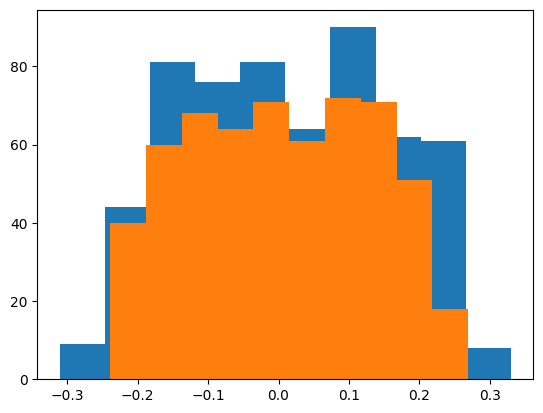

In [202]:
state_dict = model.state_dict()
hinet_weight = state_dict["hinet.inv_blocks.0.r.conv1.weight"]
hinet_r_weight = state_dict["hinet_r.inv_blocks.0.r.conv1.weight"]
diff = hinet_r_weight - hinet_weight
print(diff.min(),diff.max(), hinet_weight.min(), hinet_weight.max(), hinet_r_weight.min(), hinet_r_weight.max())
plot.hist(hinet_weight.reshape(-1,))
plot.hist(hinet_r_weight.reshape(-1,))

In [435]:
# load audio
# name = "speech7"
# dataset = load_dataset("librispeech_asr")
# data = dataset["train.clean.100"][10000]
# _, sound, sr = data["audio"].values()
# sound = torch.tensor(sound).unsqueeze(0).float()
# torchaudio.save(f"src/output_test/{name}/origin.wav", sound, sr)


# audio_path = f"src/output_test/{name}/origin.wav"
# audio_path = "VALL-E_1.wav"
# sound, sr = torchaudio.load(audio_path)
# sound = sound[:, :16000]
# torchaudio.save(f"src/output_test/{name}/watermarked.wav", sound, sr)

# load from dataset
(sequence, sequence_binary), sound, transcript, text_prompt, shift_sound = dataset[324]
print(shift_sound)
sr = 16000
start = 8000
sound = sound[None, start:start+sr]
print(transcript)
    
print(f"original sound len: {sound.shape}")
sound, _ = preprocess_audio(sound,args.num_points, shift_ratio=args.shift_ratio)
# sound = sound[:,4000:4000+model.num_points]
print(f"Preprocessed sound len: {sound.shape}")

# play the audio
sound = sound[None,:]
Audio(sound, rate=sr)

[]
 Do you love anyone?
original sound len: torch.Size([1, 16000])
Preprocessed sound len: torch.Size([16000])


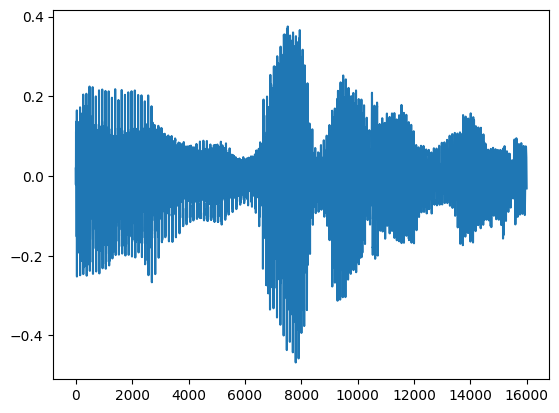

In [436]:
plot.plot(sound.squeeze(0))

In [437]:
# generate secret
# secret = torch.normal(0.4, 0.2, (32,))
# secret = torch.tensor(pattern[:32]).float()
secret = torch.rand(args.watermark_len)

secret_binary = (secret > 0.5).int()
secret, secret_binary = secret.unsqueeze(0), secret_binary.unsqueeze(0)
print(f"secret: {secret_binary}")

secret: tensor([[0, 0, 1, 0, 0, 0, 1, 1]], dtype=torch.int32)


In [438]:
model_used = model
device = "cuda"
model_used.to(device)
# run model
# cover_fft, containers_fft, container_wav, revealed = model(secret, sound)

# encode
container_wav = model_used.encode(secret.to(device), sound.to(device))

# voice cloning
# audio_prompt_path = "suno_tts_b.wav"
# transcript = "I used to work at a fire hydrant factory and you know you couldn't park anywhere near the place."
# text_prompt = "Hello, my name is Ray"
# cloned_voice, sr_clone = voice_cloner.clone(audio_prompt_path=audio_prompt_path, text_prompt=text_prompt, transcript=transcript)

cloned_voice, sr_clone = container_wav.clone().detach(), sr
# decode
revealed, audio_restore = model_used.decode(container_wav)
# audio_restore = model.restore(container_wav, secret)

In [439]:
# fake
# fake_cloned_voice = torch.normal(0, 1e-2, (cloned_voice.shape[0], cloned_voice.shape[1])).to(device)
# revealed, audio_restore = model_used.decode(fake_cloned_voice)

In [440]:
model_used, secret, sound, container_wav, revealed, audio_restore = model_used.to("cpu"), secret.cpu(), sound.cpu(), container_wav.cpu(), revealed.cpu(), audio_restore.cpu()

In [441]:
# play watermarked_audio
container_wav_np = container_wav.detach().numpy()
print(f"watermarked sound shape: {container_wav_np.shape}")
Audio(container_wav_np, rate=sr)

watermarked sound shape: (1, 16000)


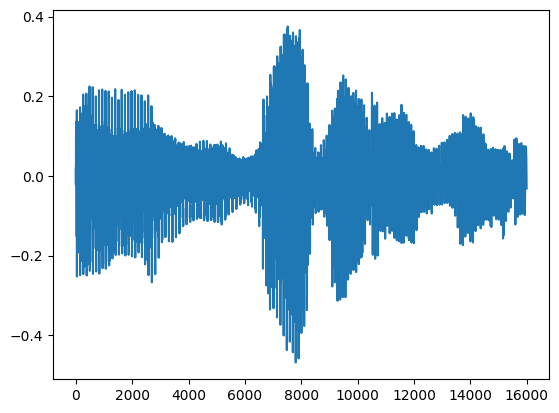

In [442]:
plot.plot(container_wav_np[0])

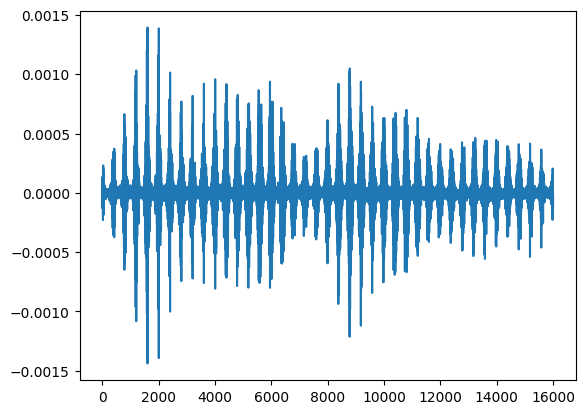

In [443]:
residual = container_wav_np[0] - sound.squeeze(0).numpy()
plot.plot(residual)

(1, 16000)


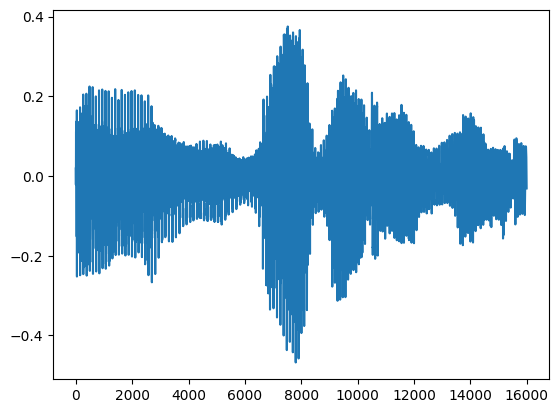

In [444]:
audio_restore_np = audio_restore.detach().numpy()
print(audio_restore_np.shape)
plot.plot(audio_restore_np[0])
Audio(audio_restore_np, rate=sr)

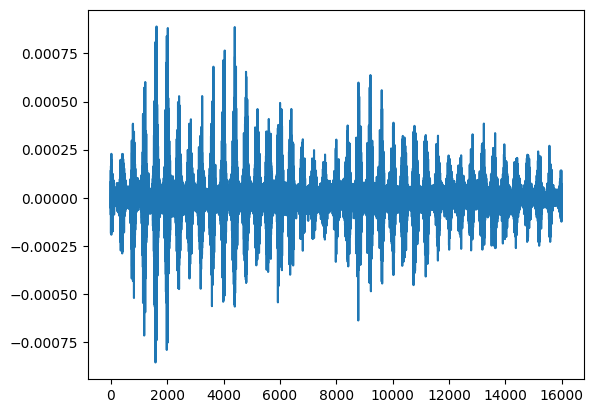

In [445]:
residual2 = audio_restore_np[0] - sound.squeeze(0).numpy()
plot.plot(residual2)

In [446]:
# evaluate
def evaluate(snd, snd_wm, srt, srt_rv):
    snr = signal_noise_ratio(snd, snd_wm)
    ber = batch_calc_ber(srt_rv, srt)

    print(f"SNR: {snr}, BER: {ber * 100}%")
    print(f"Secret: {(srt > 0.5).int()} (the number of 1: {(srt > 0.5).sum()}/{len(srt[0])})")
    print(f"Revealed: {(srt_rv > 0.5).int()}")
    # with open(f"src/output_test/{name}/metric.txt", "w") as f:
    #     f.write(f"SNR: {snr}, BER: {ber * 100}%\n")
    #     f.write(f"Secret: {(srt > 0.5).int()} (the number of 1: {(srt > 0.5).sum()}/{len(srt[0])})\n")
    #     f.write(f"Revealed: {(srt_rv > 0.5).int()}")
    

sound_np = sound.numpy()[0,:]
container_wav_np = container_wav.detach().numpy()
container_wav_np = container_wav_np.squeeze(0)
evaluate(sound_np, container_wav_np, secret, revealed)

SNR: 54.3286657333374, BER: 0.0%
Secret: tensor([[0, 0, 1, 0, 0, 0, 1, 1]], dtype=torch.int32) (the number of 1: 3/8)
Revealed: tensor([[0, 0, 1, 0, 0, 0, 1, 1]], dtype=torch.int32)


In [447]:
snr_restore = signal_noise_ratio(sound_np, audio_restore_np[0])
snr_restore

57.42777347564697

In [216]:
# decode again
revealed2, audio_restore2 = model.decode(audio_restore)
revealed2_bin = revealed2 > 0.5

revealed_bin = revealed > 0.5

print((revealed2_bin == revealed_bin).sum() / revealed_bin.size(-1))

tensor(0.5000)


In [217]:
# load from dataset
(sequence, sequence_binary), sound, transcript, text_prompt, shift_sound = dataset[1]
sr = 16000
start = 8000
sound = sound[None, start:start+sr]
print(transcript)
sound, _ = preprocess_audio(sound,args.num_points, shift_ratio=args.shift_ratio)

# play the audio
sound = sound[None,:]
Audio(sound, rate=sr)

 House cleaning. Age.


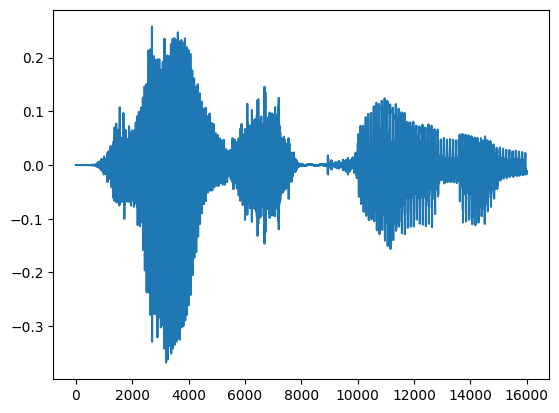

In [218]:
plot.plot(sound.squeeze(0))

In [259]:
# add watermark twice
def generate_wm():
    wm = torch.rand(args.watermark_len)
    
    wm_bin = (wm > 0.5).int()
    return wm.unsqueeze(0), wm_bin.unsqueeze(0) 

def c2d(wm):
    return (wm > 0.5).int()

watermarks = []
wm_deep = 3
for i in range(wm_deep):
    wm_tmp, wm_tmp_bin = generate_wm()
    watermarks.append(wm_tmp)   
    print(f"Watermark{i}: {wm_tmp_bin}")

Watermark0: tensor([[0, 1, 1, 1, 0, 0, 0, 0]], dtype=torch.int32)
Watermark1: tensor([[1, 1, 1, 0, 0, 1, 0, 0]], dtype=torch.int32)
Watermark2: tensor([[1, 1, 1, 1, 1, 0, 1, 0]], dtype=torch.int32)


In [260]:
%%time
# device
device = "cuda"
model.to(device)
model2.to(device)
# encode
container = sound
for i in range(wm_deep):
    if i == 0:
        container = model.encode(watermarks[i].to(device), sound.to(device))
    else:
        container = model.encode(watermarks[i].to(device), container.to(device))
# decode
reveal_wms = []
audio_restore = container
for i in range(wm_deep - 1, -1, -1):
    if i == 0:
        revealed, audio_restore = model.decode(audio_restore.to(device))
    else:
        revealed, audio_restore = model.decode(audio_restore.to(device))
    reveal_wms.append(revealed.to("cpu"))
reveal_wms = reveal_wms[::-1]


CPU times: user 54.4 ms, sys: 2.26 ms, total: 56.7 ms
Wall time: 56 ms


In [261]:
snr_restore = signal_noise_ratio(sound.numpy(), container.to("cpu").detach().numpy())
print(snr_restore)
Audio(container.to("cpu").detach().numpy(), rate=sr)

43.48679065704346


In [262]:
def check_reveal_acc(wm, wm_r):
    wm_bin = (wm > 0.5)
    wm_r_bin = (wm_r > 0.5)
    return (wm_bin == wm_r_bin).int().sum() / wm_bin.size(-1)

accs = []
for i in range(wm_deep):
    acc_tmp = check_reveal_acc(watermarks[i], reveal_wms[i])
    accs.append(acc_tmp)

for i in range(wm_deep):
    print(f"original{i}: {c2d(watermarks[i]).tolist()}\nrevealed{i}: {c2d(reveal_wms[i]).tolist()}, acc: {accs[i].item()}")
    print()

original0: [[0, 1, 1, 1, 0, 0, 0, 0]]
revealed0: [[1, 1, 1, 1, 0, 1, 0, 0]], acc: 0.75

original1: [[1, 1, 1, 0, 0, 1, 0, 0]]
revealed1: [[1, 1, 1, 0, 0, 1, 0, 0]], acc: 1.0

original2: [[1, 1, 1, 1, 1, 0, 1, 0]]
revealed2: [[1, 1, 1, 1, 1, 0, 1, 0]], acc: 1.0



 husband privately that if he was a canary bird she should want to


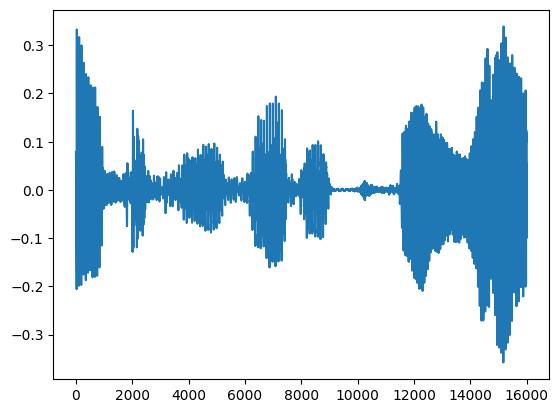

In [302]:
(sequence, sequence_binary), sound, transcript, text_prompt, shift_sound = dataset[3]
sr = 16000
start = 8000
sound = sound[None, start:start+sr]
print(transcript)
sound, _ = preprocess_audio(sound,args.num_points, shift_ratio=args.shift_ratio)

plot.plot(sound.squeeze(0))

# play the audio
sound = sound[None,:]
Audio(sound, rate=sr)

In [402]:
def run(log=True, depth=3):
    # add watermark twice
    watermarks = []
    wm_deep = depth
    # default_watermarks = [[1, 1, 0, 1, 1, 0, 0, 0], [0, 0, 0, 1, 0, 1, 1, 0], [1, 0, 1, 1, 1, 0, 0, 0]]
    # watermarks = [torch.tensor(i).float().unsqueeze(0) for i in default_watermarks]
    for i in range(wm_deep):
        wm_tmp, wm_tmp_bin = generate_wm()
        watermarks.append(wm_tmp)
        if log:
            print(f"Watermark{i}: {wm_tmp_bin}")

    # device
    device = "cuda"
    model.to(device)
    model2.to(device)
    # encode
    container = sound
    for i in range(wm_deep):
        if i == 0:
            container = model.encode(watermarks[i].to(device), sound.to(device))
        else:
            container = model.encode(watermarks[i].to(device), container.to(device))
    # decode
    reveal_wms = []
    audio_restore = container
    for i in range(wm_deep - 1, -1, -1):
        if i == 0:
            revealed, audio_restore = model.decode(audio_restore.to(device))
        else:
            revealed, audio_restore = model.decode(audio_restore.to(device))
        reveal_wms.append(revealed.to("cpu"))
    reveal_wms = reveal_wms[::-1]

    snr_restore = signal_noise_ratio(sound.numpy(), container.to("cpu").detach().numpy())
    if log:
        print(snr_restore)

    accs = []
    for i in range(wm_deep):
        acc_tmp = check_reveal_acc(watermarks[i], reveal_wms[i])
        accs.append(acc_tmp)
    if log:
        for i in range(wm_deep):
            print(f"original{i}: {c2d(watermarks[i]).tolist()}\nrevealed{i}: {c2d(reveal_wms[i]).tolist()}, acc: {accs[i].item()}")
            print()
    return watermarks, accs 

In [395]:
ret = run()
print(ret)

Watermark0: tensor([[1, 0, 0, 0, 1, 1, 1, 1]], dtype=torch.int32)
Watermark1: tensor([[1, 1, 1, 1, 0, 0, 0, 0]], dtype=torch.int32)
Watermark2: tensor([[1, 1, 1, 1, 1, 1, 0, 0]], dtype=torch.int32)
44.69579219818115
original0: [[1, 0, 0, 0, 1, 1, 1, 1]]
revealed0: [[1, 0, 0, 1, 0, 0, 0, 0]], acc: 0.375

original1: [[1, 1, 1, 1, 0, 0, 0, 0]]
revealed1: [[1, 0, 0, 1, 0, 0, 0, 0]], acc: 0.75

original2: [[1, 1, 1, 1, 1, 1, 0, 0]]
revealed2: [[1, 1, 1, 1, 1, 1, 0, 0]], acc: 1.0

([tensor([[0.6045, 0.0960, 0.0091, 0.1143, 0.5451, 0.6117, 0.7079, 0.5212]]), tensor([[0.9549, 0.6061, 0.8039, 0.9961, 0.1756, 0.3769, 0.0166, 0.0754]]), tensor([[0.9496, 0.7735, 0.5688, 0.7660, 0.9684, 0.7585, 0.2030, 0.3405]])], [tensor(0.3750), tensor(0.7500), tensor(1.)])


In [399]:
%time
for _ in range(10000):
    watermarks, accs = run(False)
    if torch.all(torch.abs(torch.tensor(accs) - 1.) < 0.001):
        print(watermarks)
        print(accs)
        print()

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 13.1 µs
[tensor([[0.4695, 0.7147, 0.8018, 0.8647, 0.7150, 0.9929, 0.1667, 0.7002]]), tensor([[0.1717, 0.9426, 0.6470, 0.9620, 0.8677, 0.9631, 0.7782, 0.7346]]), tensor([[0.9957, 0.7936, 0.0496, 0.8598, 0.3205, 0.7758, 0.6659, 0.3328]])]
[tensor(1.), tensor(1.), tensor(1.)]

[tensor([[0.6838, 0.9143, 0.6651, 0.2519, 0.8433, 0.2774, 0.4236, 0.5945]]), tensor([[0.5616, 0.0627, 0.9983, 0.1188, 0.8047, 0.3148, 0.0323, 0.9771]]), tensor([[0.4634, 0.3736, 0.7137, 0.0676, 0.9828, 0.7453, 0.4628, 0.5730]])]
[tensor(1.), tensor(1.), tensor(1.)]

[tensor([[0.9739, 0.2613, 0.7627, 0.9798, 0.5683, 0.0978, 0.6770, 0.4389]]), tensor([[0.9146, 0.1141, 0.5916, 0.7536, 0.8517, 0.3377, 0.6121, 0.1540]]), tensor([[0.4003, 0.1228, 0.2460, 0.5413, 0.5503, 0.7125, 0.5426, 0.0335]])]
[tensor(1.), tensor(1.), tensor(1.)]

[tensor([[0.1875, 0.3171, 0.0507, 0.2634, 0.6590, 0.0640, 0.6728, 0.2713]]), tensor([[0.1653, 0.1860, 0.4191, 0.9481, 0.2773, 0.2626, 0

In [401]:
%time
n = 0
for _ in range(10000):
    watermarks, accs = run(False)
    if torch.all(torch.abs(torch.tensor(accs) - 1.) < 0.001):
        print(watermarks)
        print(accs)
        print()
        n += 1
print(n)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.1 µs
[tensor([[0.3216, 0.9400, 0.9813, 0.0493, 0.2622, 0.2780, 0.2861, 0.4143]]), tensor([[0.6351, 0.0646, 0.6000, 0.2060, 0.5639, 0.6173, 0.3356, 0.8297]]), tensor([[0.6069, 0.5748, 0.3737, 0.3911, 0.3131, 0.8712, 0.2333, 0.1893]])]
[tensor(1.), tensor(1.), tensor(1.)]

[tensor([[0.1886, 0.8374, 0.5966, 0.0356, 0.1505, 0.2737, 0.1892, 0.3444]]), tensor([[0.7877, 0.3557, 0.0925, 0.7664, 0.2701, 0.7224, 0.6821, 0.6970]]), tensor([[0.0628, 0.3847, 0.8498, 0.8602, 0.1117, 0.4848, 0.9497, 0.1418]])]
[tensor(1.), tensor(1.), tensor(1.)]

[tensor([[0.3566, 0.9540, 0.3175, 0.6953, 0.1482, 0.3737, 0.3781, 0.5843]]), tensor([[0.1381, 0.3531, 0.3262, 0.9940, 0.6855, 0.6352, 0.6493, 0.1039]]), tensor([[0.5455, 0.6343, 0.2859, 0.2786, 0.0145, 0.1129, 0.4586, 0.9375]])]
[tensor(1.), tensor(1.), tensor(1.)]

[tensor([[0.1213, 0.1910, 0.1115, 0.9048, 0.3843, 0.0198, 0.4409, 0.3436]]), tensor([[0.6289, 0.4715, 0.7846, 0.2100, 0.3421, 0.4413, 0

In [403]:
%time
n = 0
for _ in range(10000):
    watermarks, accs = run(False, 4)
    if torch.all(torch.abs(torch.tensor(accs) - 1.) < 0.001):
        print(watermarks)
        print(accs)
        print()
        n += 1
print(n)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 12.9 µs
0


In [55]:
acc = 0
itern = 10000
for _ in range(itern):
    _, t_bin1 = generate_wm()
    _, t_bin2 = generate_wm()
    t_bin1 = c2d(t_bin1)
    t_bin2 = c2d(t_bin2)
    acc += (t_bin1 == t_bin2).sum() / t_bin1.shape[-1]
acc /= itern
print(acc)

tensor(0.5021)
